In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
pd.set_option('display.max_columns', None)

In [3]:
BASE_PATH = '../../data/'
customers = pd.read_csv(BASE_PATH + 'customers.csv')
articles = pd.read_csv(BASE_PATH + 'articles.csv', dtype={
    "article_id": str,
    "product_code": str
})
transactions = pd.read_csv(BASE_PATH + 'transactions_train.csv', dtype={
    "article_id": str,
})
submissions = pd.read_csv(BASE_PATH + 'sample_submission.csv')

# Utilities

In [3]:
def print_na(series):
    """
    Prints the number of missing values (and a percentage) of a series
    """
    na_count = series.isna().sum()
    na_fraction = na_count / len(series)
    print(f'missing values: {na_count} ({100*na_fraction:.2f}%)')


def find_inconsistencies(df, key_column, related_column):
    """
    Finds out if rows with the same key in the key column all have the same value in the related column
    If all keys map to a unique value in the related column, None is returned
    If some keys map to multiple values in the related column, the first key that does so together with all the unique values in the related column are returned
    
    Parameters
    df: the dataframe on which the inconsistencies are searched
    key_column: name of column in df
    related_column: name of column in df

    Returns: None or a tuple(key and list of values)
    """
    
    inconsistency = None
    for key in df[key_column].unique():
        related_values = df[related_column][df[key_column] == key]
        if len(related_values.unique()) != 1:
            inconsistency = (key, related_values.unique())
            break
    return inconsistency

def print_inconsistencies(df, key_column, related_column):
    """
    Prints the results of find_inconsistencies
    """
    inconsistency = find_inconsistencies(df, key_column, related_column)
    if inconsistency is None:
        print(f'No inconsistencies from {key_column} -> {related_column}')
    else:
        print(f'At least one inconsistency from {key_column} -> {related_column}:')
        print(f'\t{inconsistency[0]:<20}{inconsistency[1]}')

def get_pairs(key_series, related_series):
    """
    Get mapping between two columns that are consistent
    Where consistent means that rows with the same key always have the same value in a related column, for all keys
    
    Returns: dict mapping keys to their unique values
    """
    results = {}
    for key in key_series.unique():
        related_values = related_series[key_series == key]
        results[key] = related_values.unique()[0]
    return results

def find_missing(ids_A, ids_B):
    """
    Finds which elements from iterable A are missing from iterable B and vice versa

    Returns: a tuple with two elements
    1) a list of elements in B that are missing from A and 
    2) a list of elements in A that are missing from B
    """
    idset_A = set(ids_A)
    idset_B = set(ids_B)
    
    missing_from_A = []
    missing_from_B = []
    
    for id_A in ids_A:
        if id_A not in idset_B:
            missing_from_B.append(id_A)

    for id_B in ids_B:
        if id_B not in idset_A:
            missing_from_A.append(id_B)

    return missing_from_A, missing_from_B

# Customers

## Conclusions

+ `customer_id` can be safely used
    + no missing values, all unique and formatted consistently (64 hex digits)
+ `FN` and `Active`
    + only contain missing values (65%) or 1.0 (35%) -> interpret as boolean
    + FN means the customer receives the "fashion news" newsletter
    + Active means active for communication (newsletter, promotions, etc.)
    + Active => FN
+ `club_member_status`
    + enum column with large majority of entries being 'ACTIVE'
    + unrelated to `Active` column
    + 0.5% missing values -> add new 'Unknown' value
+ `fashion_news_frequency`
    + enum column
    + 1% missing -> add new 'Unknown' value
    + related to FN and Active but not exactly
+ `age`
    + no impossible values
    + between 16 and 99
    + small fraction missing (1%)
+ `postal_code` can be safely used
    + no missing values, all unique and formatted consistently
    + `2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c` is overrepresented and likely signifies a missing value

## Validate

In [4]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [5]:
# ids are unique, never missing and formatted correctly
print(f'customer count: {len(customers)}')
print(f'unique customer ids: {len(customers.customer_id.unique())}')
print(f'customer ids with 64 hex ditis: {customers.customer_id.str.match("[a-f0-9]{64}").sum()}')
print_na(customers.customer_id)

customer count: 1371980
unique customer ids: 1371980
customer ids with 64 hex ditis: 1371980
missing values: 0 (0.00%)


In [6]:
# FN is either 1 (~35%) or missing (~65%)
# -> FN is probably supposed to be a boolean field with missing values being false
print(customers.FN.value_counts())
print(f'fraction FN==1: {100*len(customers[customers.FN == 1.0]) / len(customers):.2f}%')
print_na(customers.FN)

FN
1.0    476930
Name: count, dtype: int64
fraction FN==1: 34.76%
missing values: 895050 (65.24%)


In [7]:
# Active is either 1.0 or missing, in about same ratio as FN
# -> missing likely means inactive
print(customers.Active.value_counts())
print(f'fraction FN==1: {100*len(customers[customers.Active == 1.0]) / len(customers):.2f}%')
print_na(customers.Active)

Active
1.0    464404
Name: count, dtype: int64
fraction FN==1: 33.85%
missing values: 907576 (66.15%)


In [8]:
# club_member_status is either ACTIVE, PRE_CREATE or LEFT_CLUB
# 6062 (~0.45%) missing values
print(customers.club_member_status.value_counts())
print_na(customers.club_member_status)

club_member_status
ACTIVE        1272491
PRE-CREATE      92960
LEFT CLUB         467
Name: count, dtype: int64
missing values: 6062 (0.44%)


In [9]:
# fashion news frequency is missing for ~1.2% of customers
print(customers.fashion_news_frequency.value_counts())
print_na(customers.fashion_news_frequency)

fashion_news_frequency
NONE         877711
Regularly    477416
Monthly         842
Name: count, dtype: int64
missing values: 16011 (1.17%)


In [10]:
# ages range between 16 and 99, no impossible values
# 1.2% of customers have no recorded age
print(customers.age.describe())
print_na(customers.age)

count    1.356119e+06
mean     3.638696e+01
std      1.431363e+01
min      1.600000e+01
25%      2.400000e+01
50%      3.200000e+01
75%      4.900000e+01
max      9.900000e+01
Name: age, dtype: float64
missing values: 15861 (1.16%)


In [11]:
# postal codes have no missing values
# all postal code are 64 character long hex strings
# top postal code is far more common than second most common postcode
# -> could be hashed null value?
vc = customers.postal_code.value_counts()

print_na(customers.postal_code)
print(f'64 hex ditis: {customers.postal_code.str.match("[a-f0-9]{64}").sum()}/{len(customers.postal_code)}')
print(f'fraction top: {vc.iloc[0] / len(customers):.1%}')
print(vc)

missing values: 0 (0.00%)
64 hex ditis: 1371980/1371980
fraction top: 8.8%
postal_code
2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    120303
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8       261
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1       159
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7       157
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145       156
                                                                     ...  
16dd7e391f305b54c01ffed87c189e33de83158d0a808d1b346222703742f638         1
5ce1c699380b3c13655347c9636043f5e64ec2538a1ee7d42dd253a584577630         1
afdedc642d01efeefec6fc8d3394724a71888ebd0ff0311eff6f34946589479d         1
4c8838d278d23029c920b9684fa4cf30a532428a445afb300eeb288685cf00e1         1
0a1a03306fb2f62164c2a439b38c0caa64b40deaae868799ccb93ac69444b79d         1
Name: count, Length: 352899, dtype: int64


## Explore

In [12]:
# custommers with missing age don't have anything in common
na_age = customers[customers.age.isna()]
print(na_age.Active.value_counts())
print(na_age.club_member_status.value_counts())
print(na_age.fashion_news_frequency.value_counts())
print(na_age.postal_code.value_counts())

Active
1.0    1175
Name: count, dtype: int64
club_member_status
PRE-CREATE    7336
ACTIVE        6236
LEFT CLUB        3
Name: count, dtype: int64
fashion_news_frequency
NONE         12441
Regularly     1205
Monthly          1
Name: count, dtype: int64
postal_code
2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    2301
7954175a5ef0ac2cfad30acf81e339dd15c08a104293426a92cb679f5c135314       7
28ec696f0cce3d5205abb10fb49d7c3bea005319b98967480edd2b9486fcb48b       4
de68b9b15aef6d8f37989ec80618c365be47461cdae0ab3d8b02a3e24813e59a       4
166b13f5055d907905b47193a4a4bbfe5f60fc627ad7307c60e5dbe5c71ae851       4
                                                                    ... 
a9b80465e53874bf2340bdabbccb3c188d2c23a0fa9b84c8017e955e3af41dd6       1
771454295110b6191b0b3f7f2a4e2693cd5f9c6ce50de330a335ac711936d255       1
aae345efb458b9bf16ec2e522ddb54bb13accacd4fedb75362a02ecec83bc77b       1
c8230be51c854928b9933f650e20bcc062b28acaed740f75e4b6acefe971e1d8       1
0bc23

In [13]:
# Active fields has nothing to do with club_member status being 'ACTIVE'
customers[customers.Active == 1].club_member_status.value_counts()

club_member_status
ACTIVE        458452
PRE-CREATE      5631
LEFT CLUB          3
Name: count, dtype: int64

In [14]:
# all Active==1 custommers also have FN==1
# for 12525 (~2.6%) of FN==1, active is missing

active_customers_count = len(customers[customers.Active == 1])
fn_customers_count = len(customers[customers.FN == 1])
val1 = len(customers[(customers.Active == 1) & (customers.FN == 1)])

print(f'P(FN | Active): {val1}/{active_customers_count} ({val1/active_customers_count:.1%})')
print(f'P(Active | FN): {val1}/{fn_customers_count} ({val1/fn_customers_count:.1%})')

P(FN | Active): 464404/464404 (100.0%)
P(Active | FN): 464404/476930 (97.4%)


In [15]:
# no direct implication from Active or FN to fashion_news_frequency
print(customers[customers.FN==1].fashion_news_frequency.value_counts(dropna=False))
print(customers[customers.Active==1].fashion_news_frequency.value_counts(dropna=False))

fashion_news_frequency
Regularly    475310
Monthly         829
NONE            789
NaN               2
Name: count, dtype: int64
fashion_news_frequency
Regularly    463106
Monthly         798
NONE            499
NaN               1
Name: count, dtype: int64


# Articles

## Conclusions

+ `article_id` can be safely used
    + no missing values, all unique and formatted consistently (10 numbers)
    + note to use as string instead of number because of leading zero
+ no missing values in any column except `detail_desc`
    + some columns do contain pseudo missing values (such as an 'Unknown' category)
    + product_type_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, and garment_group_no have these
+ `detail_desc`
    + < 0.5% missing values
        + probably okay to replace with empty string
        + alternative is to populate with value from other column (such as product_type_name) because no values are missing in those
    + filled in values are at least 10 characters
+ most `X_no/code/id` columns map uniquely to their respective `X_name` columns (i.e. same id implies same name)
    + exception: product_code
    + for most it is a one-to-one relationship (i.e. id  implies name and vice versa)
    + for X=`product_type`, `department`, and `section` it is a many-to-one relationship
        + (e.g. product_type_name 'Umbrella' is used for product_type_no 532 AND 83
    + best to use no/code/id everywhere
+ `product_code` doesn't map to any column
+ `product_type_no` maps to `product_type_group_name` (belongs-to relationship)
+ `index_code` maps to `index_group_no` (belongs-to relationship)

## Validate

In [16]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,0108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,0108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,0108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,0110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,0110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [17]:
print(f'article count: {len(articles)}')
print(f'unique article ids: {len(articles.article_id.unique())}')
print(f'article ids that are 10 numbers: {articles.article_id.str.match("[0-9]{10}").sum()}')
print_na(customers.customer_id)

article count: 105542
unique article ids: 105542
article ids that are 10 numbers: 105542
missing values: 0 (0.00%)


In [18]:
# no columns have missing values except 'detail_desc' which has below 0.5% missing values
for k in articles.keys():
    print(f'{k:25}', end="\t")
    print_na(articles[k])

article_id               	missing values: 0 (0.00%)
product_code             	missing values: 0 (0.00%)
prod_name                	missing values: 0 (0.00%)
product_type_no          	missing values: 0 (0.00%)
product_type_name        	missing values: 0 (0.00%)
product_group_name       	missing values: 0 (0.00%)
graphical_appearance_no  	missing values: 0 (0.00%)
graphical_appearance_name	missing values: 0 (0.00%)
colour_group_code        	missing values: 0 (0.00%)
colour_group_name        	missing values: 0 (0.00%)
perceived_colour_value_id	missing values: 0 (0.00%)
perceived_colour_value_name	missing values: 0 (0.00%)
perceived_colour_master_id	missing values: 0 (0.00%)
perceived_colour_master_name	missing values: 0 (0.00%)
department_no            	missing values: 0 (0.00%)
department_name          	missing values: 0 (0.00%)
index_code               	missing values: 0 (0.00%)
index_name               	missing values: 0 (0.00%)
index_group_no           	missing values: 0 (0.00%)
index_

In [19]:
# detail_desc contains at least 11 characters
articles.detail_desc.map(lambda s: len(s) < 11, na_action='ignore').sum()

0

In [20]:
# no/code/id -> name
print('\nX_no/code/id -> X_name')
print_inconsistencies(articles, 'product_code', 'prod_name')
print_inconsistencies(articles, 'product_type_no', 'product_type_name')
print_inconsistencies(articles, 'graphical_appearance_no', 'graphical_appearance_name')
print_inconsistencies(articles, 'colour_group_code', 'colour_group_name')
print_inconsistencies(articles, 'perceived_colour_value_id', 'perceived_colour_value_name')
print_inconsistencies(articles, 'perceived_colour_master_id', 'perceived_colour_master_name')
print_inconsistencies(articles, 'department_no', 'department_name')
print_inconsistencies(articles, 'index_code', 'index_name')
print_inconsistencies(articles, 'index_group_no', 'index_group_name')
print_inconsistencies(articles, 'section_no', 'section_name')
print_inconsistencies(articles, 'garment_group_no', 'garment_group_name')

# name -> no/code/id
print('\nX_name -> X_no/code/id')
print_inconsistencies(articles, 'prod_name', 'product_code')
print_inconsistencies(articles, 'product_type_name', 'product_type_no')
print_inconsistencies(articles, 'graphical_appearance_name', 'graphical_appearance_no')
print_inconsistencies(articles, 'colour_group_name', 'colour_group_code')
print_inconsistencies(articles, 'perceived_colour_value_name', 'perceived_colour_value_id')
print_inconsistencies(articles, 'perceived_colour_master_name', 'perceived_colour_master_id')
print_inconsistencies(articles, 'department_name', 'department_no')
print_inconsistencies(articles, 'index_name', 'index_code')
print_inconsistencies(articles, 'index_group_name', 'index_group_no')
print_inconsistencies(articles, 'section_name', 'section_no')
print_inconsistencies(articles, 'garment_group_name', 'garment_group_no')

# extra relations
print('\nExtra')
print_inconsistencies(articles, 'product_type_no', 'product_group_name')
print_inconsistencies(articles, 'product_group_name', 'product_type_no')
print_inconsistencies(articles, 'index_code', 'index_group_no')
print_inconsistencies(articles, 'index_group_no', 'index_code')
print_inconsistencies(articles, 'colour_group_code', 'perceived_colour_value_id')

# product_code
print("\nProduct code")
print_inconsistencies(articles, 'product_code', 'product_type_no')
print_inconsistencies(articles, 'product_code', 'graphical_appearance_no')
print_inconsistencies(articles, 'product_code', 'colour_group_code')
print_inconsistencies(articles, 'product_code', 'perceived_colour_value_id')
print_inconsistencies(articles, 'product_code', 'perceived_colour_master_id')
print_inconsistencies(articles, 'product_code', 'department_no')
print_inconsistencies(articles, 'product_code', 'index_code')
print_inconsistencies(articles, 'product_code', 'index_group_no')
print_inconsistencies(articles, 'product_code', 'section_no')
print_inconsistencies(articles, 'product_code', 'garment_group_no')

# no/code/id columns uniquely define name columns except in the case of product_code -> prod_name
# some names are used for than one id (in the columns prod_name, product_type_name, department_name and section_name)

# groups:
# product_type_no belongs a single product_type_group_name, but the reverse is not true
# index_code belong to a single index_group, but the reverse is not true 


X_no/code/id -> X_name
At least one inconsistency from product_code -> prod_name:
	0108775             ['Strap top' 'Strap top (1)']
No inconsistencies from product_type_no -> product_type_name
No inconsistencies from graphical_appearance_no -> graphical_appearance_name
No inconsistencies from colour_group_code -> colour_group_name
No inconsistencies from perceived_colour_value_id -> perceived_colour_value_name
No inconsistencies from perceived_colour_master_id -> perceived_colour_master_name
No inconsistencies from department_no -> department_name
No inconsistencies from index_code -> index_name
No inconsistencies from index_group_no -> index_group_name
No inconsistencies from section_no -> section_name
No inconsistencies from garment_group_no -> garment_group_name

X_name -> X_no/code/id
At least one inconsistency from prod_name -> product_code:
	6P SS BODY          ['0147339' '0634036']
At least one inconsistency from product_type_name -> product_type_no:
	Umbrella            [532 

In [8]:
# All these leggings are 'Trousers', but two are actually 'Jersey'?
articles[articles.product_code == '0241412']

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
430,0241412034,0241412,AOP Leggings,273,Leggings/Tights,Garment Lower body,1010001,All over pattern,8,Dark Grey,4,Dark,12,Grey,5962,Jersey Fancy DS,D,Divided,2,Divided,58,Divided Selected,1005,Jersey Fancy,Leggings in patterned jersey with an elasticat...
431,0241412037,0241412,AOP Leggings,273,Leggings/Tights,Garment Lower body,1010014,Placement print,9,Black,4,Dark,5,Black,5962,Jersey Fancy DS,D,Divided,2,Divided,58,Divided Selected,1005,Jersey Fancy,Leggings in patterned jersey with an elasticat...
432,0241412038,0241412,AOP Leggings,273,Leggings/Tights,Garment Lower body,1010001,All over pattern,33,Dark Orange,7,Medium,18,Red,1649,Trousers DS,D,Divided,2,Divided,58,Divided Selected,1009,Trousers,Leggings in patterned jersey with an elasticat...
433,0241412043,0241412,AOP Leggings,273,Leggings/Tights,Garment Lower body,1010001,All over pattern,14,Dark Beige,4,Dark,11,Beige,1649,Trousers DS,D,Divided,2,Divided,58,Divided Selected,1009,Trousers,Leggings in patterned jersey with an elasticat...
434,0241412044,0241412,AOP Leggings,273,Leggings/Tights,Garment Lower body,1010001,All over pattern,42,Red,7,Medium,18,Red,1649,Trousers DS,D,Divided,2,Divided,58,Divided Selected,1009,Trousers,Leggings in patterned jersey with an elasticat...
435,0241412045,0241412,AOP Leggings,273,Leggings/Tights,Garment Lower body,1010001,All over pattern,93,Dark Green,4,Dark,19,Green,1649,Trousers DS,D,Divided,2,Divided,58,Divided Selected,1009,Trousers,Leggings in patterned jersey with an elasticat...
436,0241412046,0241412,AOP Leggings,273,Leggings/Tights,Garment Lower body,1010001,All over pattern,9,Black,4,Dark,5,Black,1649,Trousers DS,D,Divided,2,Divided,58,Divided Selected,1009,Trousers,Leggings in patterned jersey with an elasticat...
437,0241412052,0241412,AOP Leggings,273,Leggings/Tights,Garment Lower body,1010009,Glittering/Metallic,9,Black,4,Dark,5,Black,1649,Trousers DS,D,Divided,2,Divided,58,Divided Selected,1009,Trousers,Leggings in patterned jersey with an elasticat...


In [21]:
# some X_no/code/id columns contains -1, identifying missing or unkown values
temp = get_pairs(articles.product_type_no, articles.product_type_name)
print('product_type')
print(temp)
print(f'Pseudo missing value: -1 -> {temp[-1]}')

temp = get_pairs(articles.graphical_appearance_no, articles.graphical_appearance_name)
print('\ngraphical_appearance')
print(temp)
print(f'Pseudo missing value: -1 -> {temp[-1]}')

temp = get_pairs(articles.colour_group_code, articles.colour_group_name)
print('\ncolour_group')
print(temp)
print(f'Pseudo missing value: -1 -> {temp[-1]}')
print(f'Pseudo missing value: 1 -> {temp[1]}')

temp = get_pairs(articles.perceived_colour_value_id, articles.perceived_colour_value_name)
print('\nperceived_colour_value')
print(temp)
print(f'Pseudo missing value: -1 -> {temp[-1]}')
print(f'Pseudo missing value: 6 -> {temp[6]}')

temp = get_pairs(articles.perceived_colour_master_id, articles.perceived_colour_master_name)
print('\nperceived_colour_master')
print(temp)
print(f'Pseudo missing value: -1 -> {temp[-1]}')
print(f'Pseudo missing value: 14 -> {temp[14]}')

temp = get_pairs(articles.department_no, articles.department_name)
print('\ndepartment')
print(temp)

temp = get_pairs(articles.index_code, articles.index_name)
print('\nindex')
print(temp)

temp = get_pairs(articles.index_group_no, articles.index_group_name)
print('\nindex_group')
print(temp)

temp = get_pairs(articles.section_no, articles.section_name)
print('\nsection')
print(temp)

temp = get_pairs(articles.garment_group_no, articles.garment_group_name)
print('\ngarment_group')
print(temp)
print(f'Pseudo missing value: 1001 -> {temp[1001]}')

product_type
{253: 'Vest top', 306: 'Bra', 304: 'Underwear Tights', 302: 'Socks', 273: 'Leggings/Tights', 252: 'Sweater', 254: 'Top', 272: 'Trousers', 72: 'Hair clip', 532: 'Umbrella', 295: 'Pyjama jumpsuit/playsuit', 256: 'Bodysuit', 73: 'Hair string', -1: 'Unknown', 308: 'Hoodie', 196: 'Sleep Bag', 74: 'Hair/alice band', 67: 'Belt', 87: 'Boots', 298: 'Bikini top', 59: 'Swimwear bottom', 286: 'Underwear bottom', 57: 'Swimsuit', 275: 'Skirt', 255: 'T-shirt', 265: 'Dress', 75: 'Hat/beanie', 307: 'Kids Underwear top', 274: 'Shorts', 259: 'Shirt', 69: 'Cap/peaked', 297: 'Pyjama set', 94: 'Sneakers', 81: 'Sunglasses', 245: 'Cardigan', 71: 'Gloves', 70: 'Earring', 66: 'Bag', 264: 'Blazer', 89: 'Other shoe', 267: 'Jumpsuit/Playsuit', 91: 'Sandals', 262: 'Jacket', 83: 'Umbrella', 277: 'Costumes', 305: 'Robe', 80: 'Scarf', 263: 'Coat', 78: 'Other accessories', 257: 'Polo shirt', 93: 'Slippers', 293: 'Night gown', 495: 'Alice band', 515: 'Straw hat', 76: 'Hat/brim', 260: 'Tailored Waistcoat', 7

# Training data

## Conclusions

+ no missing values
+ all customers and articles are known
    + but not all known articles or customers have interactions
+  `sales_channel_id` is about 30% 1 and 70% 2
    + 2 means online
    + 1 means in-store 
+  `price` has no signifcant outliers and seems reasonably distributed
    + vales are rescaled
    + articles generally have the same price across transactions, but occasionally seem to be discounted

## Validate

In [22]:
transactions.head(10)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2
5,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687001,0.016932,2
6,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221001,0.020322,2
7,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,0688873012,0.030492,1
8,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,0501323011,0.053373,1
9,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,0598859003,0.045746,2


In [23]:
# no missing values :D
print(transactions.isna().any())
print(f'transaction count: {len(transactions)}')

t_dat               False
customer_id         False
article_id          False
price               False
sales_channel_id    False
dtype: bool
transaction count: 31788324


In [24]:
# all customer with interactions are known, but not all known customers have transactions
transaction_customers = transactions.customer_id.unique()
known_customers = customers.customer_id
mysterious_customers, missing_customers = find_missing(transaction_customers, known_customers)

print(f'known customers: {len(known_customers)}')
print(f'customers with transactions: {len(transaction_customers)}')
print(f'missing customers: {len(missing_customers)}')
print(f'customers without transactions: {len(mysterious_customers)} ({100 * len(mysterious_customers)/len(known_customers):.2f}%)')

known customers: 1371980
customers with transactions: 1362281
missing customers: 0
customers without transactions: 9699 (0.71%)


In [25]:
# all articles with interactions are known, but not all known articles have transactions
transaction_articles = transactions.article_id.unique()
known_articles = articles.article_id
mysterious_articles, missing_articles = find_missing(transaction_articles, known_articles)

print(f'known articles: {len(known_articles)}')
print(f'articles with transactions: {len(transaction_articles)}')
print(f'missing articles: {len(missing_articles)}')
print(f'articles without transactions: {len(mysterious_articles)} ({100 * len(mysterious_articles)/len(known_articles):.2f}%)')

known articles: 105542
articles with transactions: 104547
missing articles: 0
articles without transactions: 995 (0.94%)


In [26]:
transactions.sales_channel_id.value_counts()

sales_channel_id
2    22379862
1     9408462
Name: count, dtype: int64

In [27]:
transactions.price.describe()

count    3.178832e+07
mean     2.782927e-02
std      1.918113e-02
min      1.694915e-05
25%      1.581356e-02
50%      2.540678e-02
75%      3.388136e-02
max      5.915254e-01
Name: price, dtype: float64

In [28]:
transactions.t_dat.min(), transactions.t_dat.max()

('2018-09-20', '2020-09-22')

In [29]:
print('March 2020:', transactions[transactions.t_dat.str.startswith('2020-03-')].sales_channel_id.value_counts(), end='\n\n')
print('April 2020:', transactions[transactions.t_dat.str.startswith('2020-04-')].sales_channel_id.value_counts(), end='\n\n')
print('May 2020:', transactions[transactions.t_dat.str.startswith('2020-05-')].sales_channel_id.value_counts(), end='\n\n')

March 2020: sales_channel_id
2    893665
1    154087
Name: count, dtype: int64

April 2020: sales_channel_id
2    1340882
Name: count, dtype: int64

May 2020: sales_channel_id
2    970069
1    391746
Name: count, dtype: int64



In [30]:
# expensive in one transactions seems to indicate expensive in other too
expensive_articles = transactions[transactions.price > 0.2].article_id.value_counts()
print("Expensive (>0.2) articles:")
print(expensive_articles)

print(f"\nPrices of {expensive_articles.index[0]}:")
print(transactions[transactions.article_id == expensive_articles.index[0]].price.value_counts())
# for i in range(10):
#     print(f"\nPrices of {expensive_articles.index[i]}:")
#     print(transactions[transactions.article_id == expensive_articles.index[i]].price.value_counts())

Expensive (>0.2) articles:
article_id
0787148001    461
0733852001    341
0763322002    299
0639338001    274
0670485001    268
             ... 
0794844001      1
0768410002      1
0615665001      1
0550801001      1
0917671001      1
Name: count, Length: 506, dtype: int64

Prices of 0787148001:
price
0.252542    326
0.189407     37
0.202034     27
0.227288     21
0.245763     11
           ... 
0.101017      1
0.198254      1
0.063136      1
0.223593      1
0.202017      1
Name: count, Length: 80, dtype: int64


# Sample Submission

## Validate

In [31]:
submissions.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [32]:
# no missing values
print(submissions.isna().any())
print(f'prediction count: {len(submissions)}')

customer_id    False
prediction     False
dtype: bool
prediction count: 1371980


In [33]:
# all known customers have exactly one prediction
submission_customers = submissions.customer_id.unique()
known_customers = customers.customer_id
_, missing_customers = find_missing(submission_customers, known_customers)

print(f'known customers: {len(known_customers)}')
print(f'customers in sample submission: {len(submission_customers)}')
print(f'missing customers: {len(missing_customers)}')

known customers: 1371980
customers in sample submission: 1371980
missing customers: 0


In [34]:
# all predictions are 12 known articles
known_articles = set(articles.article_id)
all_good = True
for pred in map(lambda x: x.split(' '), submissions.prediction.values):
    if len(pred) != 12:
        all_good = pred
        break
    for p in pred:
        if p not in known_articles:
            all_good = p
            break

print(f"all predictions are 12 known articles: {all_good}")

all predictions are 12 known articles: True


# Visualisations

<Axes: xlabel='Age'>

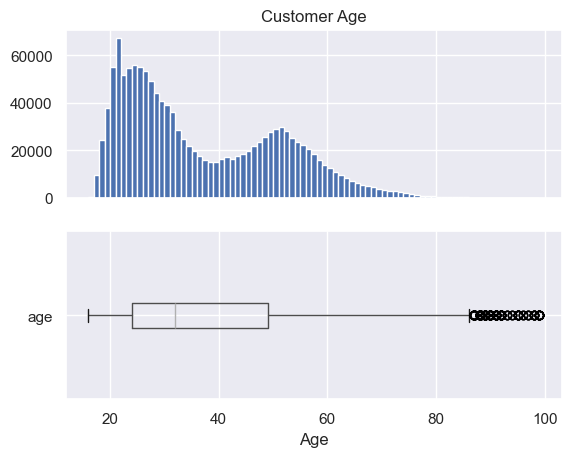

In [35]:
fig, axes = plt.subplots(nrows=2, sharex=True)
customers.age.hist(bins=int(customers.age.max()-customers.age.min()), ax=axes[0])
axes[1].set_xlabel('Age')
axes[0].set_title('Customer Age')
customers.boxplot('age', ax=axes[1], vert=False)

Text(0.5, 1.0, 'Active')

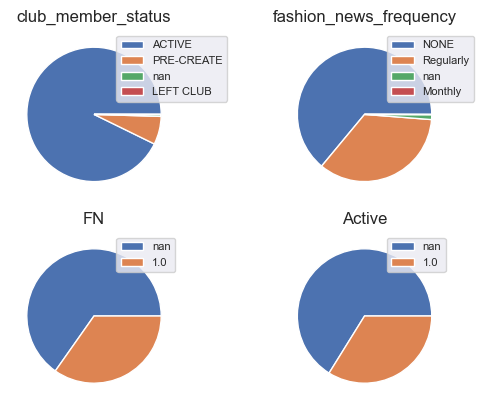

In [36]:
fig, axes = plt.subplots(ncols=2, nrows=2)

df1 = customers.club_member_status.value_counts(dropna=False)
df2 = customers.fashion_news_frequency.value_counts(dropna=False)
df3 = customers.FN.value_counts(dropna=False)
df4 = customers.Active.value_counts(dropna=False)

axes[0][0].pie(df1)
axes[0][0].legend(df1.index, loc='upper left', fontsize=8, bbox_to_anchor=(0.6, 1))
axes[0][0].axis('off')
axes[0][0].set_title('club_member_status')

axes[0][1].pie(df2)
axes[0][1].legend(df2.index, loc='upper left', fontsize=8, bbox_to_anchor=(0.6, 1))
axes[0][1].axis('off')
axes[0][1].set_title('fashion_news_frequency')

axes[1][0].pie(df3)
axes[1][0].legend(df3.index, loc='upper left', fontsize=8, bbox_to_anchor=(0.6, 1))
axes[1][0].axis('off')
axes[1][0].set_title('FN')

axes[1][1].pie(df4)
axes[1][1].legend(df4.index, loc='upper left', fontsize=8, bbox_to_anchor=(0.6, 1))
axes[1][1].axis('off')
axes[1][1].set_title('Active')

Text(0.5, 1.0, 'index_group_name')

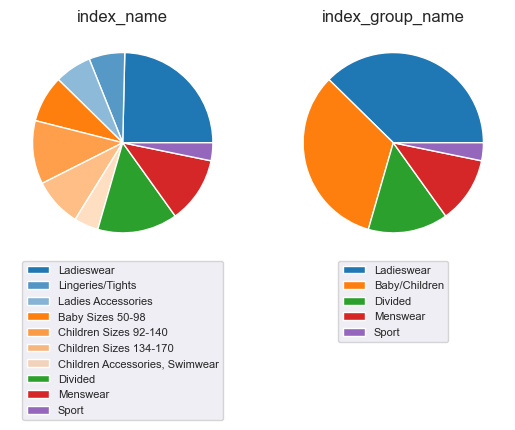

In [37]:
df1_order = ['Ladieswear', 'Lingeries/Tights', 'Ladies Accessories', 'Baby Sizes 50-98', 'Children Sizes 92-140', 'Children Sizes 134-170', 'Children Accessories, Swimwear', 'Divided', 'Menswear', 'Sport']
df1 = articles.index_name.value_counts()
df1 = pd.Series({k: df1[k] for k in df1_order})
df2 = articles.index_group_name.value_counts()


fig, axes = plt.subplots(ncols=2)

axes[0].pie(df1.values, colors=[('tab:blue', 1), ('tab:blue', 0.75), ('tab:blue', 0.5), ('tab:orange', 1), ('tab:orange', 0.75), ('tab:orange', 0.5), ('tab:orange', 0.25), 'tab:green', 'tab:red', 'tab:purple'])
axes[0].legend(df1.index, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 0))
axes[0].axis('off')
axes[0].set_title('index_name')

axes[1].pie(df2, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
axes[1].legend(df2.index, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 0))
axes[1].axis('off')
axes[1].set_title('index_group_name')

perceived_colour_value_name
Dark            42706
Dusty Light     22152
Light           15739
Medium Dusty    12630
Bright           6471
Medium           5711
Undefined         105
Unknown            28
Name: count, dtype: int64

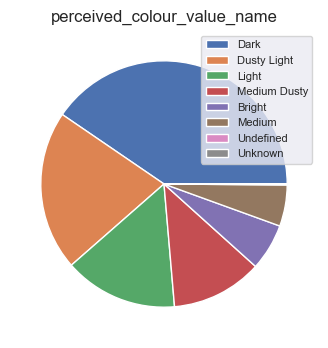

In [38]:
fig, ax = plt.subplots(ncols=1, figsize=(4,4))

df = articles.perceived_colour_value_name.value_counts()
ax.pie(df)
ax.legend(df.index, loc='upper right', fontsize=8)
ax.axis('off')
ax.set_title('perceived_colour_value_name')
df

0.2959722569834132

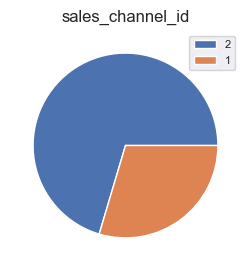

In [39]:
fig, ax = plt.subplots(ncols=1, figsize=(3,3))

df = transactions.sales_channel_id.value_counts()

ax.pie(df)
ax.legend(df.index, loc='upper right', fontsize=8)
ax.axis('off')
ax.set_title('sales_channel_id')

df[1] / (df[1]+df[2])

number of transactions with price exceeding 0.001: 31774036 (99.96%)
number of transactions with price exceeding 0.01: 28631131 (90.07%)
number of transactions with price exceeding 0.02: 19400551 (61.03%)
number of transactions with price exceeding 0.03: 11870584 (37.34%)
number of transactions with price exceeding 0.04: 6159329 (19.38%)
number of transactions with price exceeding 0.05: 3728801 (11.73%)
number of transactions with price exceeding 0.1: 318629 (1.00%)
number of transactions with price exceeding 0.2: 20691 (0.07%)
number of transactions with price exceeding 0.3: 3888 (0.01%)


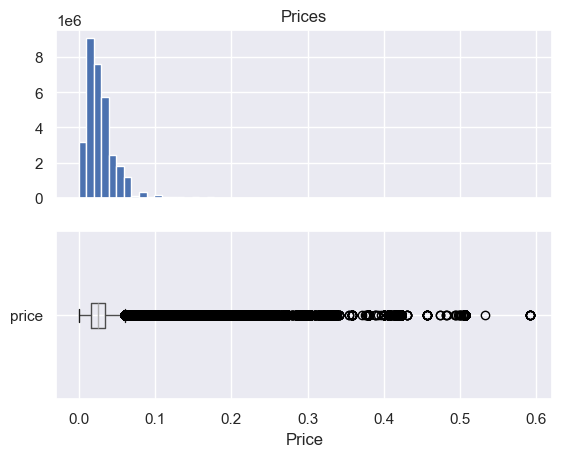

In [40]:
fig, axes = plt.subplots(nrows=2, sharex=True)
transactions.price.hist(bins=60, ax=axes[0])
axes[1].set_xlabel('Price')
axes[0].set_title('Prices')
transactions.boxplot('price', ax=axes[1], vert=False)

num_transactions = len(transactions)
for lim in [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3]:
    count = len(transactions[transactions.price > lim])
    print(f'number of transactions with price exceeding {lim}: {count} ({100 * count/num_transactions:.2f}%)')